In [1]:
import os
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import spacy
#nlp = spacy.load('en_core_web_lg')
from gensim.models import Word2Vec
os.chdir("C:/Users/Kieran Mepham/Google Drive/Course Docs/PhD/ETH - Social Networks through Time/BARJ")
case_metadata = pd.read_csv(os.path.join(os.getcwd(),"case_metadata.csv"))
case_metadata["case_id"] = case_metadata["caseid"]
doc_features = pd.read_pickle("doc_features.pkl")
doc_features = pd.merge(doc_features,case_metadata[['case_id','x_republican']],on='case_id', how='left')
#doc_features.to_pickle("doc_features_repub.pkl")

#getting judge affiliations in same length list as sentences
sents = []
j_affil = []
for i, doc in enumerate(doc_features["spacy_doc"]):
    sents.extend(list(doc.sents))
    j_affil.extend([doc_features.iloc[i]["x_republican"]] * len(list(doc.sents)))

# this pickle contains sentences which I ran spacy over - I had to redo this since the POS tags were completely 
# disordered after I split the documents to sentences 
sents_df = pd.read_pickle("sents_nlp_df.pkl")



In [3]:
# pos tags that I want to filter out
rm_pos = ("PUNCT", "SPACE", "NUM", "SYM", "PRON")

# this function takes the lemmas, in lower case, removing pronouns, digits, and punctuation, and splits each
# one into a list of words
def norm_text(doc):
    text = []
    for token in doc:
        if token.pos_ not in ("PUNCT", "SPACE", "NUM", "SYM", "PRON"):
            text.append(token.lemma_)
    return text

sents_df["processed"] = [norm_text(sent) for sent in sents_df["sents_nlp"]]
sents_df["j_affil"] = j_affil


# take the lemma of all adjectives for problem 2 - these will match the words in the word vectors
adjectives = []
for sent in sents_df["sents_nlp"]:
    temp = [token.lemma_ for token in sent if token.pos_ == "ADJ"]
    adjectives.extend(temp)
adjectives = list(set(adjectives))

In [4]:

# Problem 1: Train a word embedding (Word2Vec, GloVe, ELMo, BERT, etc) on your corpus, once with a small window (e.g. 2)
# and again with a long window (e.g. 16). What do you expect to change for the different window sizes? Pick a sample of
# 100 words and visualize them in two dimensions, to demonstrate the difference between the models.

# I suspect that magnitude of word associations to the 2 vectors will be a bit more clustered in the larger window since
# there are more observations so less susceptible to noise (and the coefficients would be more robust/generalizable)

model_short = Word2Vec(sents_df["processed"], size=200, window=2, min_count=20, workers=4)
model_long = Word2Vec(sents_df["processed"], size=200, window=16, min_count=20, workers=4)

# getting the vectors from the trained model
w_vecs_2 = pd.DataFrame({'word': model_short.wv.index2word,
                         's1': model_short.wv.vectors[:,0],
                         's2': model_short.wv.vectors[:,1],
                         'l1': model_long.wv.vectors[:,0],
                         'l2': model_long.wv.vectors[:,1]})
random.seed(1)
s_w_vecs_2 = w_vecs_2.sample(n = 100)


# plotting: I tried ggplot as in the notebook, but apparently it is incompatible with later versions of pandas. 
plt.scatter(s_w_vecs_2["s1"], s_w_vecs_2["s2"], alpha=0.5)
plt.title('Scatterplot short window')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



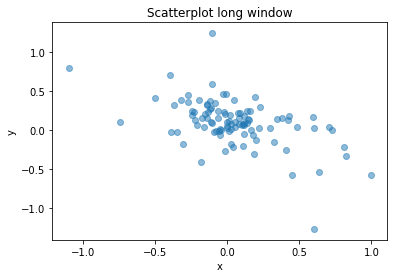

To be honest, I don't see anything interestingly different here - everything seems essentially grouped 
 in 1 spot/over 1 line. The words look more clustered, but this is likely mostly due to the change in scale of the plots.


In [13]:
plt.scatter(s_w_vecs_2["l1"], s_w_vecs_2["l2"], alpha=0.5)
plt.title('Scatterplot long window')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("To be honest, I don't see anything interestingly different here - everything seems essentially grouped \n in 1 spot/over 1 line. The words look more clustered, but this is likely mostly due to the change in scale of the plots.")


In [16]:
# Problem 2: Train separate word embeddings for Republican and Democrat judges. Use your word embeddings to list the
# adjectives most associated with a social group or concept of your choice, and analyze differences by judge party.

sents_r = sents_df.loc[sents_df['j_affil'] == 1]
sents_d = sents_df.loc[sents_df['j_affil'] == 0]

model_r = Word2Vec(sents_r["processed"], size=200, window=16, min_count=5, workers=4)
model_d = Word2Vec(sents_d["processed"], size=200, window=16, min_count=5, workers=4)

# getting adjectives that are represented in the respective corpuses
adj_r = [adj for adj in adjectives if adj in model_r.wv.index2word]
adj_d = [adj for adj in adjectives if adj in model_d.wv.index2word]

# I use the adjectives list to filter the words most "similar" to words representing women
# I would have liked to try distance, too, but this did not seem to be playing nicely with the lists of multiple words
adj_r_women = [item for item in model_r.wv.most_similar(["female", "woman", "girl"],
                                            topn=300)
    if item[0] in adj_r]

adj_d_women = [item for item in model_d.wv.most_similar(["female", "woman", "girl"],
                                            topn=300)
    if item[0] in adj_d]
print("Adjectives used about women by Republicans:")
print(pd.DataFrame(adj_r_women[0:20]))
print("\n \n Adjectives used about women by Democrats") 
print(pd.DataFrame(adj_d_women[0:20]))

print("\n \n I personally do not see too much evidence of positive or negative bias on the part of either kind of judge. Perhaps \n \
that the first word relating to women is 'spoiled', and words such as 'questionable' and 'narcotic' are somewhat negative \n on \
the Republicans' part, but 'nervous' and 'crude' would indicate the same from the Democrats.")

Adjectives used about women by Republicans:
               0         1
0          sharp  0.984431
1            2nd  0.971293
2          empty  0.970643
3    inescapable  0.967906
4       narcotic  0.967004
5       straight  0.964874
6      detective  0.964293
7   unsuccessful  0.964205
8          alert  0.963933
9          ready  0.963617
10           few  0.962210
11         flush  0.961351
12         front  0.961225
13          loco  0.959555
14           key  0.958702
15         frank  0.958599
16       distant  0.955657
17         rapid  0.955565
18     wholesale  0.955440
19          24th  0.952994

 
 Adjectives used about women by Democrats
               0         1
0            die  0.981629
1    experienced  0.980562
2         mobile  0.976328
3            mid  0.975199
4          daily  0.973591
5        interim  0.973341
6            pat  0.973308
7       narcotic  0.972160
8            dry  0.972113
9       powerful  0.971831
10         hindu  0.971061
11          mass  0.

In [ ]:
# I did not have time to reach the third problem. If I get time, this will be updated over the weekend. Apologies.